# Analysis of high background for dynamic background patch

## Trapping the image centroid with high background

With no background subtraction, it takes only a moderate high background
of 300 e-/sec to trap the slot image centroid for a 10.0 mag star.
For a 10.5 mag star only 190 e-/sec will trap the star.

## Threshold for setting MS flag

One idea for mitigating DOTR is to use readout values from the 32 outer-ring pixels
(those used in the dynamic background sampling) to detect a high background situation.
In cases where the background is "high" then set the multiple stars ACA status flag
for that readout.

In order to avoid false positives for a bright star at T_ccd = 0 C, a threshold of at
least 500 e-/sec is needed.

In [1]:
from functools import lru_cache

from chandra_aca.aca_image import ACAImage, AcaPsfLibrary
from chandra_aca.transform import mag_to_count_rate
from chandra_aca.dark_model import dark_temp_scale
from mica.archive.aca_dark import get_dark_cal_props
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('bmh')


## Trapping the image centroid with high background

With no background subtraction, it takes only a moderate high background
to trap the slot image centroid.

In [2]:
apl = AcaPsfLibrary()

In [3]:
# 10th mag star at row, col = 2.0, 2.0
ct_rate = mag_to_count_rate(10.0)
star = apl.get_psf_image(row=2.0, col=2.0, norm=ct_rate, pix_zero_loc='edge')

In [4]:
star.aca.centroid_fm(pix_zero_loc='edge')

(1.99978450060892, 1.9997586815834167, 6911.222994770643)

In [5]:
bgd = ACAImage(shape=(8, 8), row0=-4, col0=-4)

In [6]:
# Make an 8x8 image where the star is offset by 2 pixels from the readout center.
# Normally the centroid reflects that the star is well off-center and the
# ACA then moves the image readout window accordingly to track the star.
img = bgd + star.aca
print(img.copy().aca.centroid_fm(pix_zero_loc='edge'))
img

(1.5207935711535363, 1.4864582169985718, 4239.6249034939)


<ACAImage row0=-4 col0=-4
array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   4,   4,   4,   3,   3],
       [  0,   0,   4,   0,  16,  21,  17,   8],
       [  0,   0,   8,  25,  97, 392, 267,  65],
       [  0,   0,  11,  45, 449, 879, 945, 308],
       [  0,   0,   7,  38, 402, 598, 818, 419],
       [  0,   0,   4,  12,  51, 247, 463,  97]])>

In [7]:
# However, with the current dynamic background, a sudden increase in the background
# is not reflected in the on-board background map. The background bias is not
# accounted for and it pulls the centroid to the center of the 6x6 mouse-bitten image.
# In this case the centroid is within 0.5 pix of the center and the readout window
# is trapped.
bgd = ACAImage(shape=(8, 8), row0=-4, col0=-4) + 300
img = bgd + star.aca
print(img.copy().aca.centroid_fm(pix_zero_loc='edge'))
img

(0.4658792664032543, 0.4553609883747134, 13839.624903493901)


<ACAImage row0=-4 col0=-4
array([[ 300,  300,  300,  300,  300,  300,  300,  300],
       [ 300,  300,  300,  300,  300,  300,  300,  300],
       [ 300,  300,  302,  304,  304,  304,  303,  303],
       [ 300,  300,  304,  300,  316,  321,  317,  308],
       [ 300,  300,  308,  325,  397,  692,  567,  365],
       [ 300,  300,  311,  345,  749, 1179, 1245,  608],
       [ 300,  300,  307,  338,  702,  898, 1118,  719],
       [ 300,  300,  304,  312,  351,  547,  763,  397]])>

This effect scales with background and star mag, so for 9.0 mag star the background
needs to be 300 * 2.5 = 750 e-/sec.

Conversely a 10.5 mag star needs only a hi background of 190 e-/sec to get trapped.

## Threshold for setting MS flag

The goal is to set the threshold as low as possible without generating false positives
for valid images with no excess background.

In [8]:
dark_props = get_dark_cal_props('2021:100', include_image=True)

In [9]:
DARK_MAP = dark_props['image']
DARK_T_CCD = dark_props['t_ccd']

In [10]:
OUTER_ROWS = np.array([0, 0, 0, 0, 0, 0, 0, 0] 
                  + [7, 7, 7, 7, 7, 7, 7, 7]
                  + [1, 2, 3, 4, 5, 6]
                  + [1, 2, 3, 4, 5, 6]
                  + [1, 1, 6, 6])
OUTER_COLS = np.array([0, 1, 2, 3, 4, 5, 6, 7]
                  + [0, 1, 2, 3, 4, 5, 6, 7]
                  + [0, 0, 0, 0, 0, 0]
                  + [7, 7, 7, 7, 7, 7]
                  + [1, 6, 1, 6])
outers = set((r, c) for r, c in zip(OUTER_ROWS, OUTER_COLS))
inner_rows = []
inner_cols = []
for row in range(8):
    for col in range(8):
        if (row, col) not in outers:
            inner_rows.append(row)
            inner_cols.append(col)
INNER_ROWS = np.array(inner_rows)
INNER_COLS = np.array(inner_cols)

In [11]:
def calc_inner_outer_sums(dark_map):
    inner_sums = []
    outer_sums = []
    for row in range(0, 1016):
        for col in range(0, 1016):
            pix = dark_map[row + OUTER_ROWS, col + OUTER_COLS]
            outer_sums.append(np.sum(pix))
            pix = dark_map[row + INNER_ROWS, col + INNER_COLS]
            inner_sums.append(np.sum(pix))
    inner_sums = np.array(inner_sums)
    outer_sums = np.array(outer_sums)
    return inner_sums, outer_sums

In [12]:
@lru_cache()
def calc_n_over(thresh, bgd, t_ccd=0, star_mag=5.8):
    dark_at_t_ccd = DARK_MAP * dark_temp_scale(DARK_T_CCD, t_ccd_ref=t_ccd) + bgd
    n_over = []
    img, *_ = apl.get_psf_image(row=3.95, col=3.95, aca_image=False, norm=mag_to_count_rate(star_mag))
    img_vals = img[OUTER_ROWS, OUTER_COLS]
    for row in range(0, 1016):
        for col in range(0, 1016):
            pix = dark_at_t_ccd[row + OUTER_ROWS, col + OUTER_COLS] + img_vals
            n_over.append(np.count_nonzero(pix > thresh))

    return np.array(n_over)

In [13]:
# inner_sums, outer_sums = calc_inner_outer_sums(DARK_MAP)

In [14]:
def get_aaaratios(bgd, star_mag, t_ccd):
    star_cts = mag_to_count_rate(star_mag)
    dark_scale = dark_temp_scale(DARK_T_CCD, t_ccd)
    bgd_sum = 32 * bgd
    outers = outer_sums * dark_scale + bgd_sum
    inners = inner_sums * dark_scale + bgd_sum + star_cts
    ratios = outers / inners
    return ratios

In [15]:
def plot_n_over_hist(thresh, bgd, t_ccd=0, star_mag=5.8):
    n_over = calc_n_over(thresh=thresh, bgd=bgd, t_ccd=t_ccd, star_mag=star_mag)
    fig, ax1 = plt.subplots(figsize=(7, 3.5))
    ax1.hist(n_over, bins=np.arange(0, 40)-0.5);
    ymin, ymax = ax1.get_ylim()
    ax1.plot([24, 24], [0, ymax], linestyle='--', color='r', scaley=False)
    # ax1.set_ylim(ymin, ymax)
    ax1.set_xlabel('Number of pixels over threshold')
    fig.suptitle(f'Pixels in dyn bgd sampling over {thresh} e-/sec at {t_ccd} C'
                  f'for bgd={bgd} and star_mag={star_mag}');

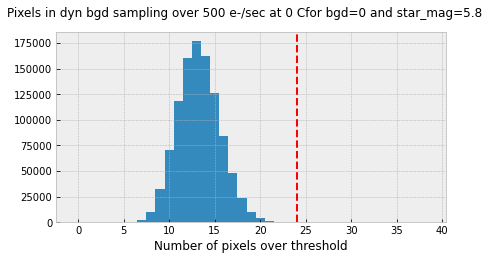

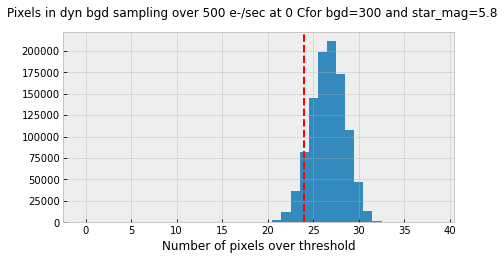

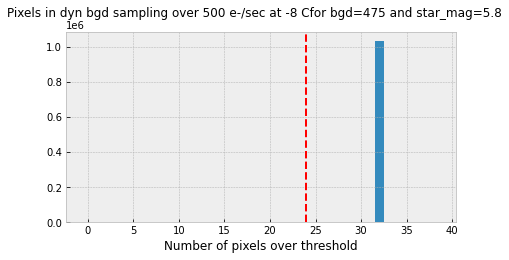

In [16]:
plot_n_over_hist(thresh=500, bgd=0, t_ccd=0, star_mag=5.8)
plot_n_over_hist(thresh=500, bgd=300, t_ccd=0, star_mag=5.8)
plot_n_over_hist(thresh=500, bgd=475, t_ccd=-8, star_mag=5.8)

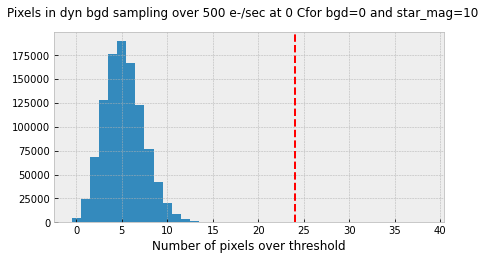

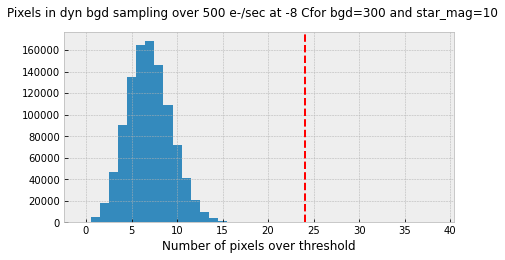

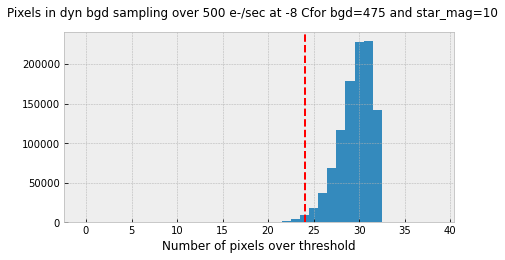

In [17]:
plot_n_over_hist(thresh=500, bgd=0, t_ccd=0, star_mag=10)
plot_n_over_hist(thresh=500, bgd=300, t_ccd=-8, star_mag=10)
plot_n_over_hist(thresh=500, bgd=475, t_ccd=-8, star_mag=10)
